 ### AdaBoost from Scratch (Adaptive Boosting)

In [27]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as img
sns.set()

from collections import Counter
from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

# set display option

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

#### Weighted Error/ Epsilon

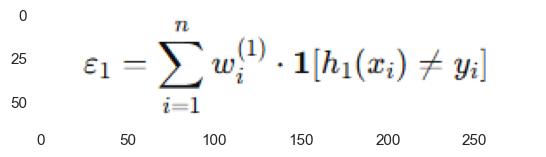

In [2]:
plt.imshow(img.imread(r'C:\Users\Atharv Soni\Palakk\Machine Learning\Supervised\Classification\ensemble_learning\boosting\ada_weighted_error.png'))
plt.grid()
plt.show();

**What is epsilon in above**

`Total weight of misclassified samples by first weak learner h_1(x).`

`It is not just count of mistakes, but it is the sum of weights of mistakes. Why?`
> * `How bad the learner was.` <br>
> * `How much trust it deserves.`

#### Confidence / Alpha

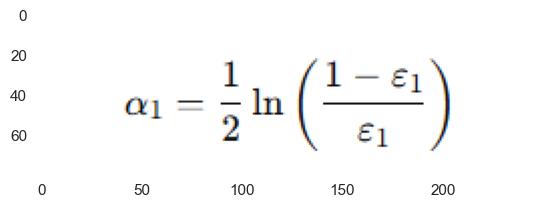

In [3]:
plt.imshow(img.imread(r'C:\Users\Atharv Soni\Palakk\Machine Learning\Supervised\Classification\ensemble_learning\boosting\learners_weight_confidence_formula.png'))
plt.grid()
plt.show();

`Alpha will` **transform the error rate** `of the learner` **into a confidence score.**

#### Weights Updation Rule

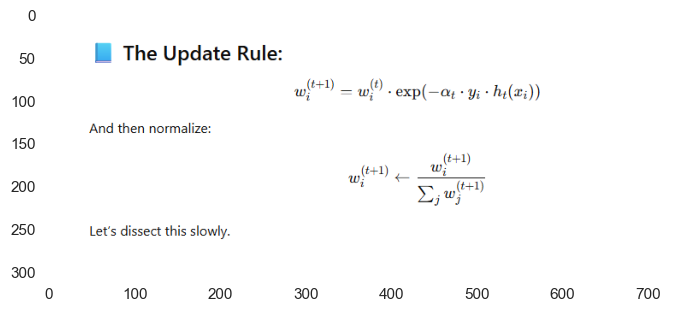

In [4]:
plt.figure(figsize= (8,8))
plt.imshow(img.imread(r'C:\Users\Atharv Soni\Palakk\Machine Learning\Supervised\Classification\ensemble_learning\boosting\update_rule.png'))
plt.grid()
plt.show();

#### Final Predictions

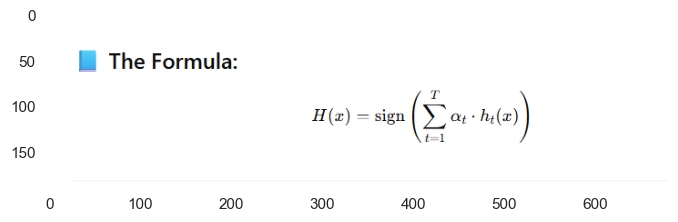

In [5]:
plt.figure(figsize= (8,8))
plt.imshow(img.imread(r'C:\Users\Atharv Soni\Palakk\Machine Learning\Supervised\Classification\ensemble_learning\boosting\weighted_majority_voting.png'))
plt.grid()
plt.show();

### Code from scratch for Binary Class

In [44]:
class DecisionStump:
    """
    A single-level decision tree that handles:
    - Numerical features (using threshold splits)
    - Categorical features (using equality splits)
    """
    def __init__(self):
        self.feature_index = None
        self.threshold = None         # For numeric split
        self.category = None          # For categorical split
        self.is_categorical = False
        self.polarity = 1             # 1 or -1, determines which side is -1
        self.alpha = None             # Learner's weight

    def predict(self, X):
        """
        Predicts labels (+1 or -1) based on learned feature and threshold/category

        Parameters:
        X: np.array of shape (n_samples, n_features)

        Returns:
        np.array of shape (n_samples,) with values +1 or -1
        """
        n_samples = X.shape[0] # no. of observations
        predictions = np.ones(n_samples) # initialization
        feature_values = X[:, self.feature_index] 

        if self.is_categorical:
            if self.polarity == 1:
                predictions[feature_values == self.category] = -1
            else:
                predictions[feature_values != self.category] = -1
        else:
            if self.polarity == 1:
                predictions[feature_values <= self.threshold] = -1
            else:
                predictions[feature_values > self.threshold] = -1

            # Apply polarity to comparison
            # if self.polarity == 1:
            #     predictions[feature_values < self.threshold] = -1
            # else:
            #     predictions[feature_values > self.threshold] = -1
                
        return predictions


class AdaBoostClassifierScratch:
    """
    AdaBoost classifier combining multiple decision stumps
    Handles categorical, numerical, and missing values
    """
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.stumps = []
        self.alphas = []

    def _is_categorical(self, feature_col):
        """
        Check if a feature column is categorical based on dtype or cardinality
        """
        return not np.issubdtype(feature_col.dtype, np.number)

    def fit(self, X, y):
        """
        Trains AdaBoost on input data X and binary targets y (-1, +1)
        """
        n_samples, n_features = X.shape
        w = np.full(n_samples, 1 / n_samples)  # Step 1: equal weights

        for _ in range(self.n_estimators):
            stump = DecisionStump()
            min_error = float('inf') # Initilization

            # Try all features
            for feature_i in range(n_features):
                feature_values = X[:, feature_i] # Filter data for each feature

                # Skip feature if too many missing values
                # Only check NaNs if the data type is numeric
                if np.issubdtype(feature_values.dtype, np.number):
                    if np.isnan(feature_values).mean() > 0.5:
                        continue


                is_cat = self._is_categorical(feature_values)
                stump.is_categorical = is_cat # updating the value

                # Handle missing values safely for both numeric and categorical
                if np.issubdtype(feature_values.dtype, np.number):
                    clean_values = feature_values[~np.isnan(feature_values)] # selecting not nan values
                else:
                    clean_values = feature_values[feature_values != None] # selecting not none values

                thresholds = np.unique(clean_values)


                for threshold in thresholds:
                    for polarity in [1, -1]:  # Try both directions
                        predictions = np.ones(n_samples)
                        '''
                        If thresholds = [A,B,C]
                        then,
                        for polarity = 1
                        for threshold = A, predictions = [1,1,1]
                        for threshold = B, predictions = [-1,1,1]
                        for threshold = C, predictions = [-1,-1,1]
                        for polarity = -1
                        for threshold = A, predictions = [1,-1,-1]
                        for threshold = B, predictions = [1,1,-1]
                        for threshold = C, predictions = [1,1,1]
                        '''
                        if polarity == 1:
                            predictions[feature_values <= threshold] = -1
                        else:
                            predictions[feature_values > threshold] = -1

                        # Step 3: compute weighted error
                        error = np.sum(w[y != predictions])

                        if error < min_error:
                            min_error = error
                            stump.feature_index = feature_i
                            stump.polarity = polarity
                            if is_cat:
                                stump.category = threshold
                                stump.threshold = None
                            else:
                                stump.threshold = threshold
                                stump.category = None
                            best_preds = predictions.copy()

            # Step 4: compute alpha
            epsilon = 1e-10 # a very small value
            stump.alpha = 0.5 * np.log((1 - min_error + epsilon) / (min_error + epsilon))

            # Step 5: update weights
            w *= np.exp(-stump.alpha * y * best_preds)
            w /= np.sum(w)  # normalize

            self.stumps.append(stump)
            self.alphas.append(stump.alpha)

    def predict(self, X):
        """
        Makes final prediction using weighted voting of all stumps

        Parameters:
        X: np.array of shape (n_samples, n_features)

        Returns:
        np.array of predictions: +1 or -1
        """
        n_samples = X.shape[0]
        final = np.zeros(n_samples)
        for stump, alpha in zip(self.stumps, self.alphas):
            pred = stump.predict(X)
            final += alpha * pred
        return np.sign(final)  # +1 or -1

In [45]:
# Example Data (XOR-like pattern)
X =  np.array([['A', 'B', 'A', 'A', 'B'],
               [1, 2, 3, 4, 5]]).T
y = np.array([+1, -1, +1, -1, -1])

# Train
model = AdaBoostClassifierScratch(n_estimators=3)
model.fit(X, y)

# Predict
print("Predictions:", model.predict(X))

Predictions: [ 1. -1.  1. -1. -1.]


### Comparing with Sklearn AdaBoost Function

In [59]:
# load iris data

X, y = load_breast_cancer(return_X_y= True)
y = np.where(y == 0, -1, 1)  # Convert 0/1 → -1/+1
X

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]], shape=(569, 30))

In [60]:
y

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  1,  1,  1,
        1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1, -1,  1, -1, -1,  1,  1,
        1,  1, -1,  1, -1, -1,  1, -1,  1, -1, -1,  1,  1,  1, -1, -1,  1,
       -1, -1, -1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1, -1, -1,  1,
        1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
       -1,  1, -1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1,  1, -1, -1,
        1,  1, -1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1, -1, -1,  1, -1,  1,  1, -1, -1,  1,
        1, -1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1,  1, -1,  1, -1,
        1,  1,  1, -1,  1,  1, -1, -1,  1, -1, -1, -1, -1,  1, -1, -1, -1,
        1, -1,  1, -1,  1,  1, -1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1,
        1,  1, -1,  1,  1

In [61]:
# Split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 9)
X_train.shape, X_test.shape

((426, 30), (143, 30))

In [62]:
X_train

array([[1.359e+01, 2.184e+01, 8.716e+01, ..., 6.189e-02, 2.446e-01,
        7.024e-02],
       [8.888e+00, 1.464e+01, 5.879e+01, ..., 4.786e-02, 2.254e-01,
        1.084e-01],
       [1.290e+01, 1.592e+01, 8.374e+01, ..., 1.012e-01, 3.549e-01,
        8.118e-02],
       ...,
       [1.382e+01, 2.449e+01, 9.233e+01, ..., 1.521e-01, 3.651e-01,
        1.183e-01],
       [1.147e+01, 1.603e+01, 7.302e+01, ..., 6.548e-02, 2.851e-01,
        8.763e-02],
       [1.205e+01, 2.272e+01, 7.875e+01, ..., 1.092e-01, 2.191e-01,
        9.349e-02]], shape=(426, 30))

In [63]:
X_test

array([[1.537e+01, 2.276e+01, 1.002e+02, ..., 1.476e-01, 2.556e-01,
        6.828e-02],
       [1.344e+01, 2.158e+01, 8.618e+01, ..., 1.112e-01, 2.994e-01,
        7.146e-02],
       [1.894e+01, 2.131e+01, 1.236e+02, ..., 1.789e-01, 2.551e-01,
        6.589e-02],
       ...,
       [8.571e+00, 1.310e+01, 5.453e+01, ..., 8.512e-02, 2.983e-01,
        1.049e-01],
       [2.047e+01, 2.067e+01, 1.347e+02, ..., 1.613e-01, 3.220e-01,
        6.386e-02],
       [1.471e+01, 2.159e+01, 9.555e+01, ..., 1.834e-01, 3.698e-01,
        1.094e-01]], shape=(143, 30))

##### AdaBoost from Sklearn

In [64]:
# create instance

ab = AdaBoostClassifier()
ab

AdaBoostClassifier()

In [65]:
# Learn the values

ab.fit(X_train, y_train)

AdaBoostClassifier()

In [66]:
ab.score(X_train, y_train)

1.0

In [67]:
ab.score(X_test, y_test)

0.972027972027972

In [68]:
# create instance

abfs = AdaBoostClassifierScratch(n_estimators= 50)
abfs

In [69]:
abfs.fit(X_train, y_train)

In [70]:
abfs.predict(X_train)

array([ 1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1.,
        1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,
        1.,  1., -1., -1.,  1., -1.,  1.,  1., -1.,  1., -1., -1., -1.,
       -1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1., -1.,  1.,
        1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,
        1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,
        1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1., -1.,
        1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1., -1.,
        1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,
        1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
        1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,
        1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,
        1.,  1.,  1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1

In [71]:
accuracy_score(y_train, abfs.predict(X_train))

1.0

In [72]:
accuracy_score(y_test, abfs.predict(X_test))

0.965034965034965

**Results are almost same**